## ZX simulation validation

Performs a set of efficiency, acceptance, and resolution plots based on the ZX toy MC samples

The notebook runs with latest software stack in SWAN

In [3]:
import ROOT
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

# plot configurations
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetPadBottomMargin(0.1)
ROOT.gStyle.SetPadLeftMargin(0.12)
ROOT.gStyle.SetPadTopMargin(0.05)
ROOT.gStyle.SetPadRightMargin(0.03)

outdir='/eos/user/p/psilva/www/EXO-19-009/signal'
url='/eos/user/p/psilva/data/ppszx/validation/ZX_validation.root'

In [1]:
#prepare output directory
import os
os.system('mkdir -p %s'%outdir)

#available info
masses=[600,800,1000,1200,1400,1600]
sides=['Pos','Neg']
titles={'multi':'multiRP','pix':'Pixels','strip':'Strips'}
ms={'multi':20,'pix':26,'strip':32}
algos=titles.keys()

vtitles={'mpp':'m(pp) [GeV]',
         'pzpp':'$p_{z}$(pp) [GeV]',
        }
vlist=vtitles.keys()
effbins={'mpp':np.linspace(0,2000,100),'pzpp':np.linspace(-1500,1500,50),'xi':np.linspace(0,0.2,20)}

fillGraphs=True

# read the data to memory
ROOT.ROOT.EnableImplicitMT()
rdf = ROOT.RDataFrame("tuple", url)
df=pd.DataFrame(rdf.AsNumpy())
df=df.rename(columns={"gen_pzpp": "pzpp_gen"})
df.head()

Welcome to JupyROOT 6.24/06


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly


mX  xangle  postTS2           wgt     pzpp_gen  csiNeg_gen  csiPos_gen  \
0  1000.0   150.0      1.0  1.668012e-12  1033.341187   -1.000000    0.036690   
1  1000.0   150.0      1.0  2.588415e-12   402.995300    0.121774    0.059775   
2  1000.0   150.0      1.0  2.795903e-12    59.375168    0.089516    0.080382   
3  1000.0   150.0      1.0  9.883045e-13 -1465.000977    0.030587   -1.000000   
4  1000.0   150.0      1.0  2.732851e-12  -224.774841    0.069292    0.103873   

       mpp_gen    mmass_gen  csiNeg_multi  ...    mpp_multi  mmass_multi  \
0    -1.000000    -1.000000     -1.000000  ...    -1.000000    -1.000000   
1  1109.125122  1000.000000      0.118525  ...  1082.677612   973.552917   
2  1102.741699  1000.000000      0.088837  ...  1093.155273   990.435791   
3    -1.000000    -1.000000     -1.000000  ...    -1.000000    -1.000000   
4  1102.898804  1000.000061      0.066831  ...  1097.015503   993.195312   

   csiNeg_pix  csiPos_pix      mpp_pix    mmass_pix  csiNeg_strip  \
0   -1.000000    0.036510    -1.000000    -1.000000     -1.000000   
1    0.122470    0.067032  1177.874146  1069.588867      0.122122   
2    0.098659    0.081879  1168.418091  1066.674683      0.097619   
3    0.033425   -1.000000    -1.000000    -1.000000     -1.000000   
4    0.047130    0.102836   905.033936   794.407104      0.049796   

   csiPos_strip    mpp_strip  mmass_strip  
0      0.036449    -1.000000    -1.000000  
1      0.065929  1166.487671  1058.112793  
2      0.081655  1160.649414  1058.814453  
3     -1.000000    -1.000000    -1.000000  
4      0.103124   931.581177   822.316650  

[5 rows x 21 columns]

### Auxiliary functions

In [14]:
def getHistoWithErrors(x,w,hbins):
    
    """ computes a weighted histogram with associated errors using error propagation """
    
    bins = np.digitize(x,hbins)    

    #project entries in each bin summing up the weights
    h=[]
    for i in range(len(hbins)):
        ni  = w[np.where(bins==i+1)[0]]
        h.append( [np.sum(ni),np.sqrt(np.sum(ni**2.))] )
    
    return np.array(h)

def getEfficiency(df,baseCut,passCut,vname,wname,hbins,debug=False):
    
    """ compute the ratio of pass/total histograms with error propagation """   
    
    df_den = df[baseCut]
    h_den  = getHistoWithErrors(x=df_den[vname].to_numpy(),
                                w=df_den[wname].to_numpy(),
                                hbins=hbins)
    df_num = df_den[passCut]
    h_num  = getHistoWithErrors(x=df_num[vname].to_numpy(),
                                w=df_num[wname].to_numpy(),
                                hbins=hbins)    
    
    #regularize the numbers to become close to 1
    regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
    regVec=np.exp(regVec,where=regVec!=np.nan,out=np.ones_like(regVec))
    h_den=(h_den.T*regVec).T
    h_num=(h_num.T*regVec).T
    
    d,ed=h_den[:,0],h_den[:,1]
    n,en=h_num[:,0],h_num[:,1]
    eff=np.true_divide(n.astype(np.double), 
                       d.astype(np.double), 
                       out=np.zeros_like(n), 
                       where=d!=0).astype(np.double)
    
    eeffn = np.sqrt( (d*en)**2 + (n*ed)**2 )
    eeffd = d*d
    eeff  = np.true_divide(eeffn.astype(np.double), 
                           eeffd.astype(np.double), 
                           out=np.zeros_like(eeffn), 
                           where=eeffd!=0,
                           dtype=np.double)
    
    eff = np.stack((eff, eeff), axis=-1)
    
    if debug:
        print('Histogram and efficency dump')
        print(np.stack((h_den,h_num,eff),axis=-1))
        
    return eff


def showEfficiencies(x,effList,titleList=None,loc='best',xtitle=None,ytitle='Acceptance',extraText=[],outpname=None,grid=True,ylim=(0,1),exts=['png','pdf']):
    
    """ a wrapper to show the efficiencies """
    
    #prepare figure
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.set_xlabel(xtitle) 
    ax.tick_params(axis='x') 
    ax.set_ylabel(ytitle)
    ax.tick_params(axis='y')
    
    #show the efficiency graphs
    for i in range(len(effList)):
        eff=effList[i]
        kwargs={'yerr':eff[:,1]}
        if titleList: kwargs['label']=titleList[i]
        plt.errorbar(x,eff[:,0],fmt='o',**kwargs)
        
    #extra text
    hep.cms.label(loc=0)
    for i in range(len(extraText)):
        ax.text(0.05,0.92-i*0.03, extraText[i], transform=ax.transAxes, style='italic')
       
    plt.legend(loc=loc)
    if grid: plt.grid(True)
    plt.ylim(*ylim)
    plt.tight_layout()
    
    if outpname:
        for ext in exts:
            plt.savefig(outpname+'.'+ext)
    plt.show()

In [4]:
# test
_=getEfficiency(df,
                baseCut=((df['mX']==600) & (df['csiPos_gen']>0)),
                passCut=(df['csiPos_multi']>0),
                vname='csiPos_gen',
                wname='wgt',
                hbins=np.linspace(0,0.2,50),
                debug=True)        

/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]


Histogram and efficency dump
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[1.03560841e+00 0.00000000e+00 0.00000000e+00]
  [5.24016693e-02 0.00000000e+00 0.00000000e+00]]

 [[1.62324917e+00 0.00000000e+00 0.00000000e+00]
  [7.03525916e-03 0.00000000e+00 0.00000000e+00]]

 [[1.77098262e+00 0.00000000e+00 0.00000000e+00]
  [5.03293332e-03 0.00000000e+00 0.00000000e+00]]

 [[1.69237769e+00 0.00000000e+00 0.00000000e+00]
  [5.32169314e-03 0.00000000e+00 0.00000000e+00]]

 [[1.49667072e+00 1.84984680e-03 1.23597449e-03]
  [5.24129905e-03 1.84947639e-04 1.23648497e-04]]

 [[1.30995774e+00 1.71511143e-01 1.30928755e-01]
  [5.04930457e-03 1.83536077e-03 1.48920459e-03]]

 [[1.15165806e+00 7.90952682e-01 6.86794698e-01]
  [4.82558785e-03 4.00

/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)


### Single RP efficiency curves, as function of the generator level xi variable

In [5]:
def fillSingleRPEffs(hbins=effbins['xi']):
    
    """fill the efficiency graphs (just needs to be done once, as it'll store the results in a pickle file)"""
    
    effGrs={}

    keys=list(itertools.product(masses,sides,algos))
    for k in keys:
        mX,side,algo=k
        effGrs[k] = getEfficiency(df,
                                  baseCut=((df['mX']==mX) & (df['csi%s_gen'%side]>0)),
                                  passCut=(df['csi%s_%s'%(side,algo)]>0),
                                  vname='csi{0}_gen'.format(side),
                                  wname='wgt',
                                  hbins=hbins)        
        
    pckF=os.path.join(outdir,'effgrs.pck')
    with open(pckF,'wb') as fout:
        pickle.dump(hbins,fout,pickle.HIGHEST_PROTOCOL)
        pickle.dump(effGrs,fout,pickle.HIGHEST_PROTOCOL)
    print('Results saved in',pckF)

if fillGraphs: fillSingleRPEffs()

/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/1669302002.py:30: RuntimeWarning: overflow encountered in exp
  regVec=np.exp(regVec,where=regVec!=np.nan,out=np.ones_like(regVec))
/tmp/ipykernel_514/1669302002.py:31: RuntimeWarning: invalid value encountered in multiply
  h_den=(h_den.T*regVec).T
/tmp/ipykernel_514/1669302002.py:32: RuntimeWarning: invalid value encountered in multiply
  h_num=(h_num.T*regVec).T
/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/1669302002.py:23: User

/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/1669302002.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!

Results saved in /eos/user/p/psilva/www/EXO-19-009/signal/effgrs.pck


/tmp/ipykernel_514/1669302002.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)


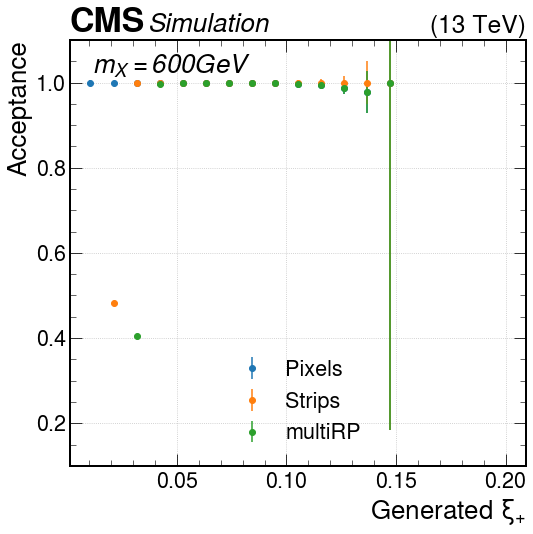

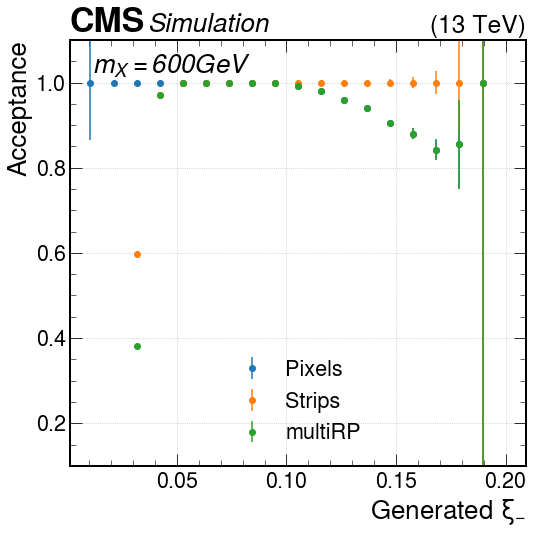

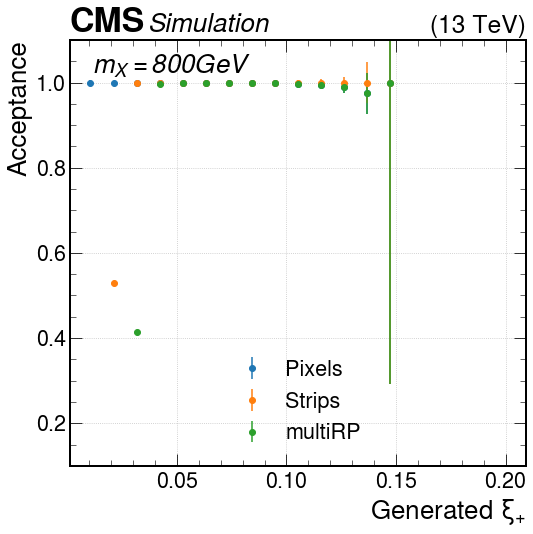

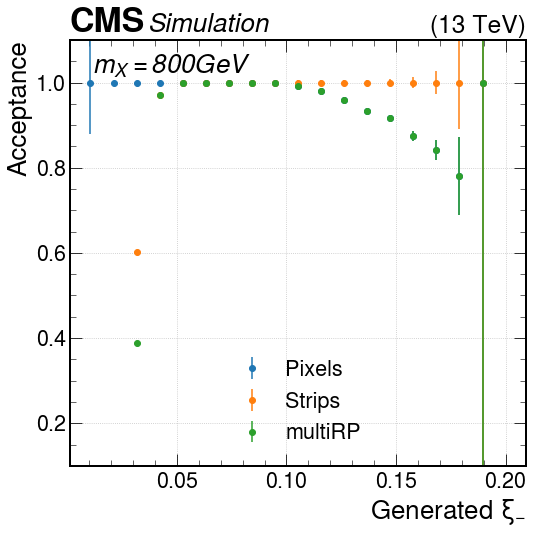

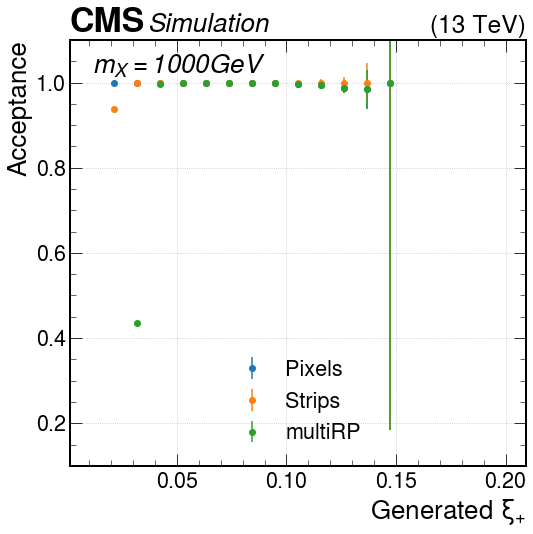

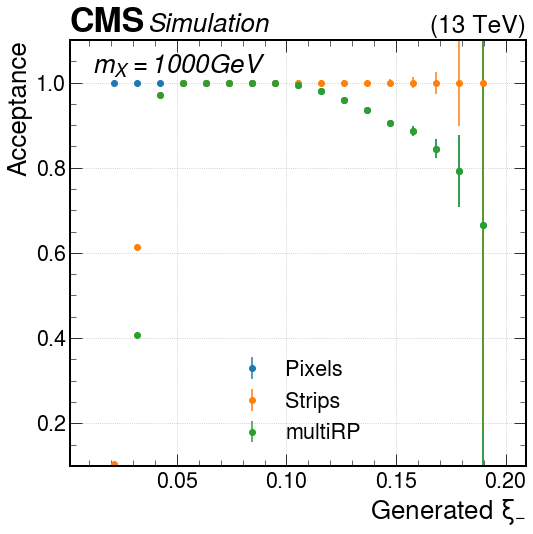

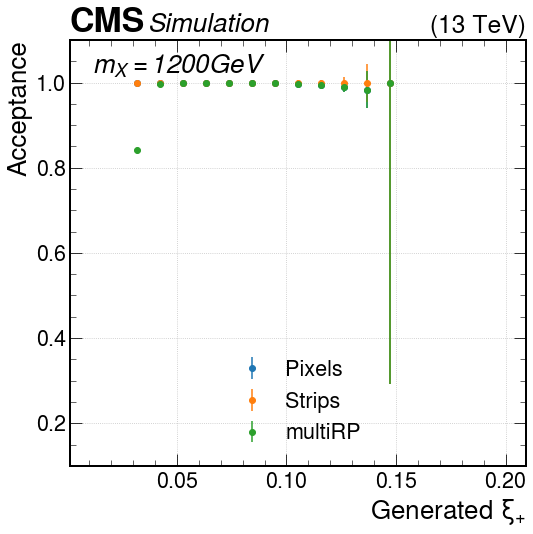

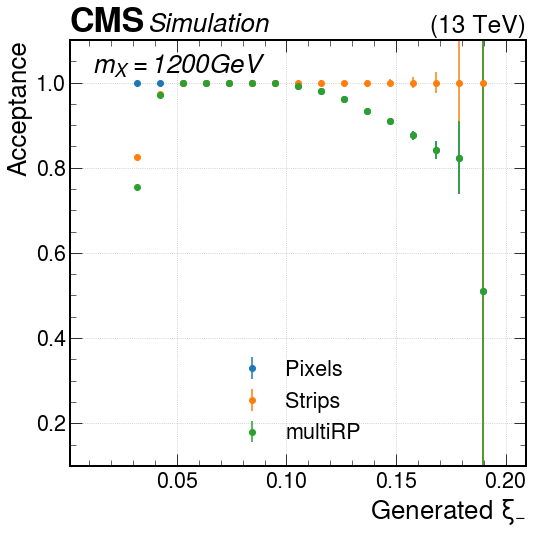

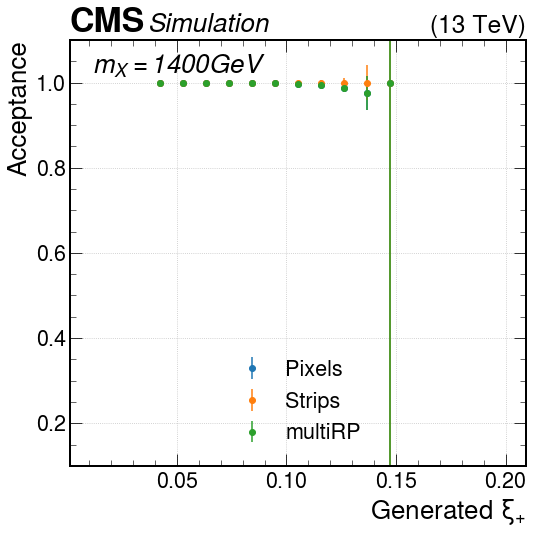

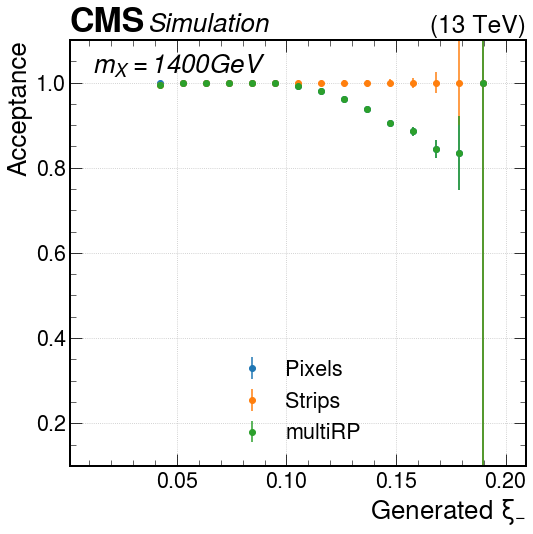

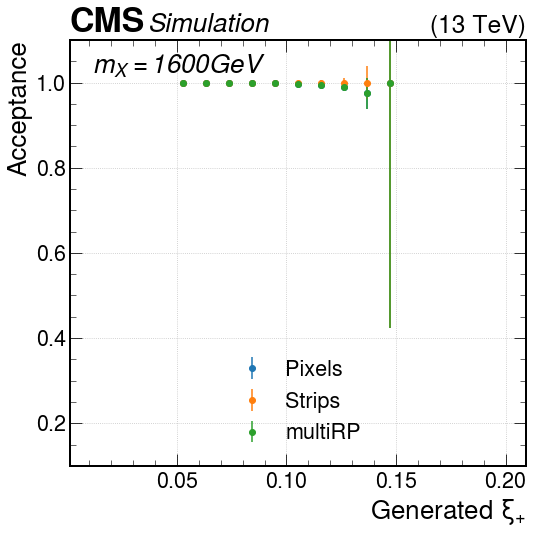

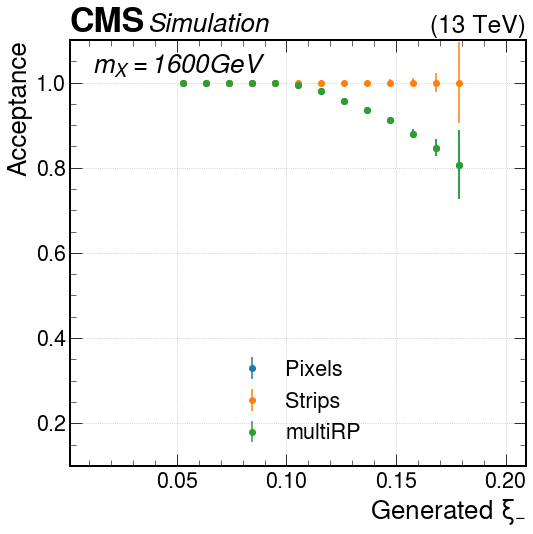

In [15]:
# display plots (reads always from the pickle file)

with open(os.path.join(outdir,'effgrs.pck'),'rb') as fin:
    x=pickle.load(fin)
    effGrs=pickle.load(fin)
    
keys=list(itertools.product(masses,sides))
for k in keys:
    
    mX,side=k
    
    effList=[]
    titleList=[]
    for a in ['pix','strip','multi']:
        grk=(mX,side,a)
        effList.append(effGrs[grk])
        titleList.append(titles[a])        
        
    showEfficiencies(x,
                     effList,
                     titleList,
                     xtitle=r'Generated $\xi_{%s}$'%('+' if side=='Pos' else '-'),
                     extraText=[r'$m_{X}=%d GeV$'%mX],
                     outpname=os.path.join(outdir,'rpeff_{0}_{1}'.format(mX,side)),
                     ylim=(0.1,1.1)
                    )    


## Combined PPS efficiency plots

In [16]:
def fillCombinedRPEffs():
    
    """ fill the combined PPS efficiency graphs (just needs to be done once, as it'll store the results in a pickle file) """

    combineEffGrs={}
    
    keys=list(itertools.product(masses,algos,vlist))
    for k in keys:
        mX,algo,v=k    
    
        combineEffGrs[k] = getEfficiency(df,
                                         baseCut=((df['mX']==mX) & (df['csiPos_gen']>0) & (df['csiNeg_gen']>0)),
                                         passCut=(df['mpp_%s'%algo]>0),
                                         vname='{0}_gen'.format(v),
                                         wname='wgt',
                                         hbins=effbins[v])
        
    pckF=os.path.join(outdir,'combeffgrs.pck')
    with open(pckF,'wb') as fout:
        pickle.dump(effbins,fout,pickle.HIGHEST_PROTOCOL)
        pickle.dump(combineEffGrs,fout,pickle.HIGHEST_PROTOCOL)
    
    print('Results saved in',pckF)

if fillGraphs: fillCombinedRPEffs()     

/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/3325149036.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/3325149036.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/3325149036.py:30: RuntimeWarning: overflow encountered in exp
  regVec=np.exp(regVec,where=regVec!=np.nan,out=np.ones_like(regVec))
/tmp/ipykernel_514/3325149036.py:31: RuntimeWarning: invalid value encountered in multiply
  h_den=(h_den.T*regVec).T
/tmp/ipykernel_514/3325149036.py:32: RuntimeWarning: invalid value encountered in multiply
  h_num=(h_num.T*regVec).T
/tmp/ipykernel_514/3325149036.py:23: User

/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/3325149036.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/3325149036.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/tmp/ipykernel_514/3325149036.py:29: RuntimeWarning: divide by zero encountered in log
  regVec=-np.floor(np.log(h_den[:,0]),where=h_den[:,0]!=0)
/tmp/ipykernel_514/3325149036.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_num = df_den[passCut]
/t

Results saved in /eos/user/p/psilva/www/EXO-19-009/signal/combeffgrs.pck


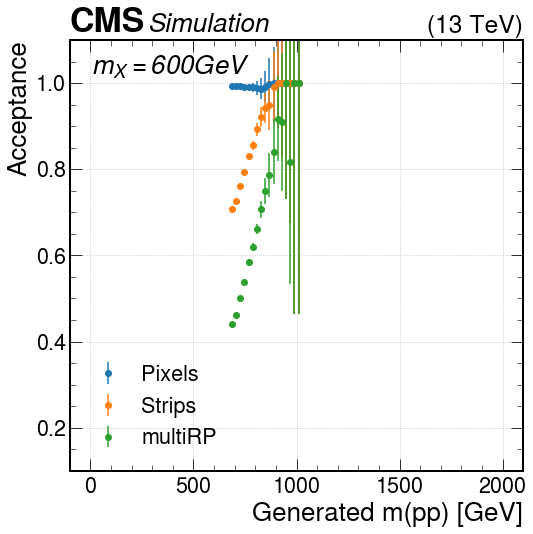

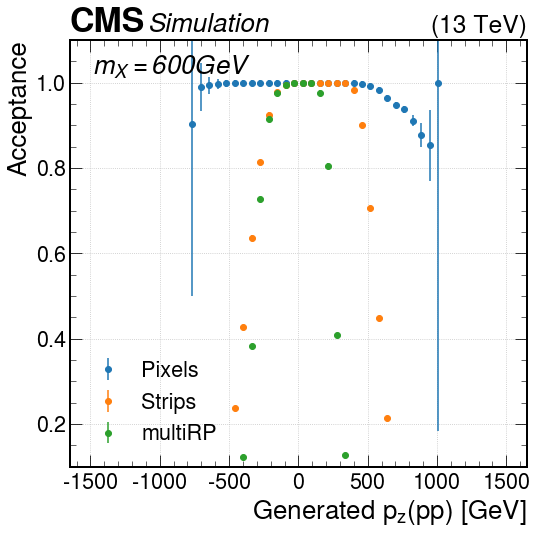

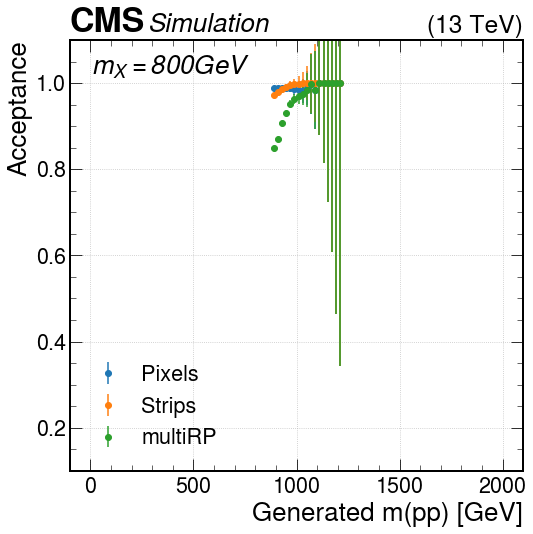

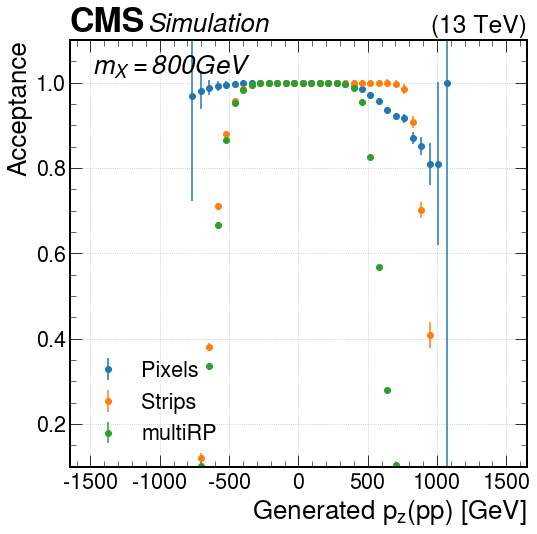

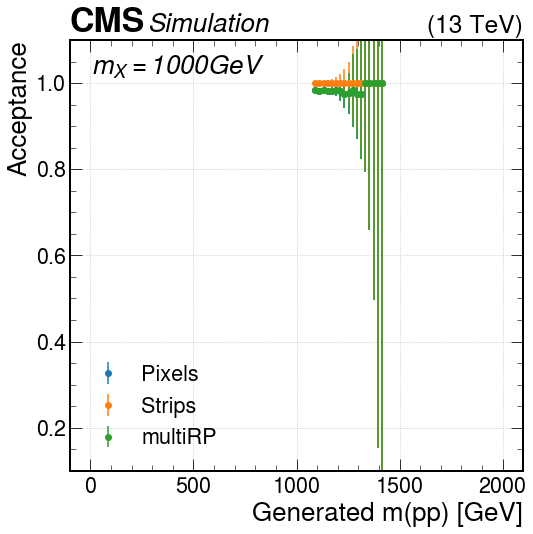

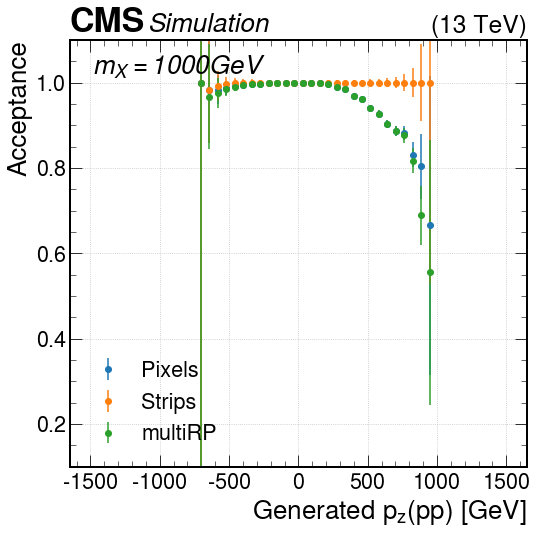

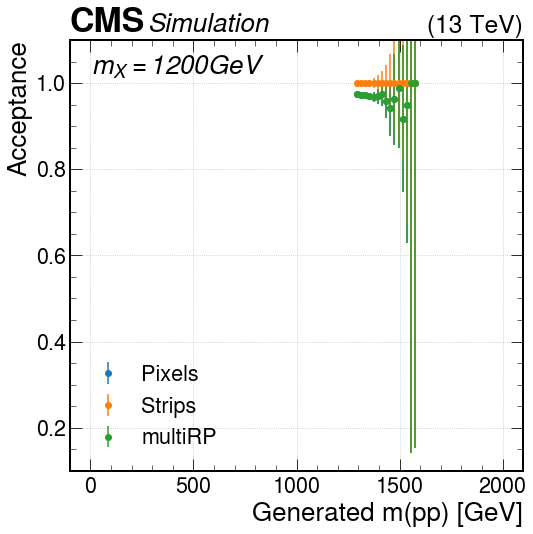

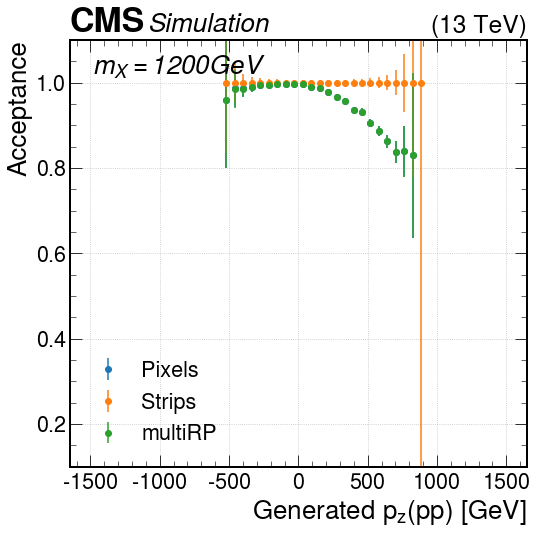

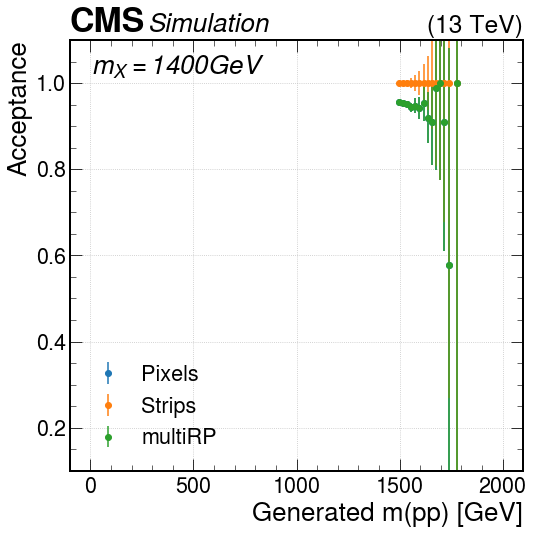

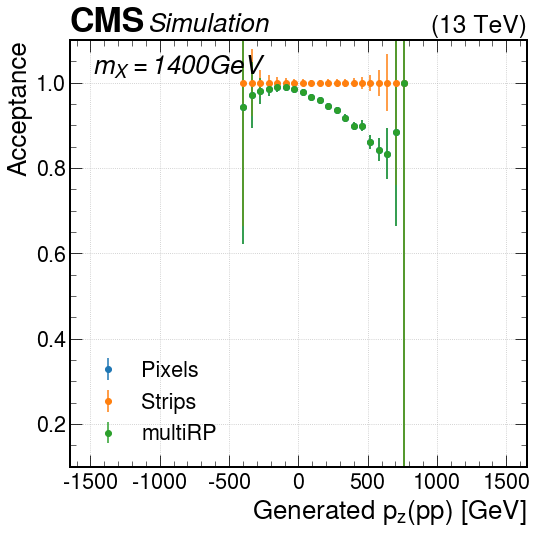

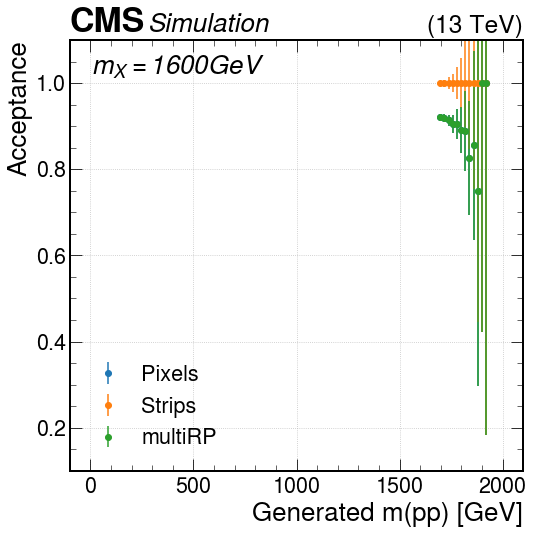

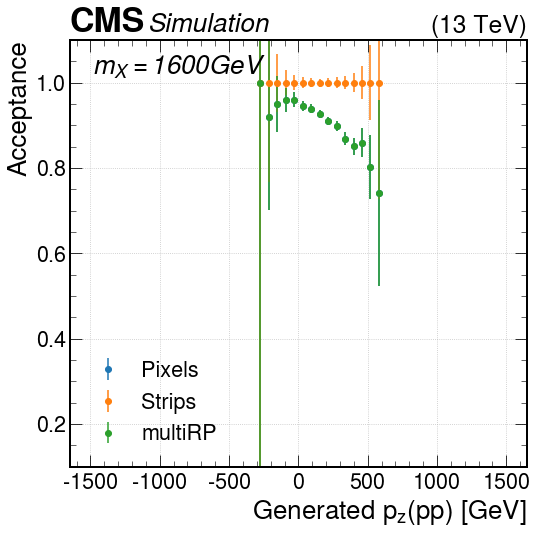

In [17]:
with open(os.path.join(outdir,'combeffgrs.pck'),'rb') as fin:
    x=pickle.load(fin)
    effGrs=pickle.load(fin)
    
keys=list(itertools.product(masses,vlist))
for k in keys:
    
    mX,v=k
    
    effList=[]
    titleList=[]
    for a in ['pix','strip','multi']:
        grk=(mX,a,v)
        effList.append(effGrs[grk])
        titleList.append(titles[a])        
        
    showEfficiencies(effbins[v],
                     effList,
                     titleList,
                     xtitle=r'Generated %s'%vtitles[v],
                     extraText=[r'$m_{X}=%d GeV$'%mX],
                     outpname=os.path.join(outdir,'combrpeff_{0}_{1}'.format(mX,v)),
                     ylim=(0.1,1.1),
                     loc='lower left'
                    )

## Resolution plots

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

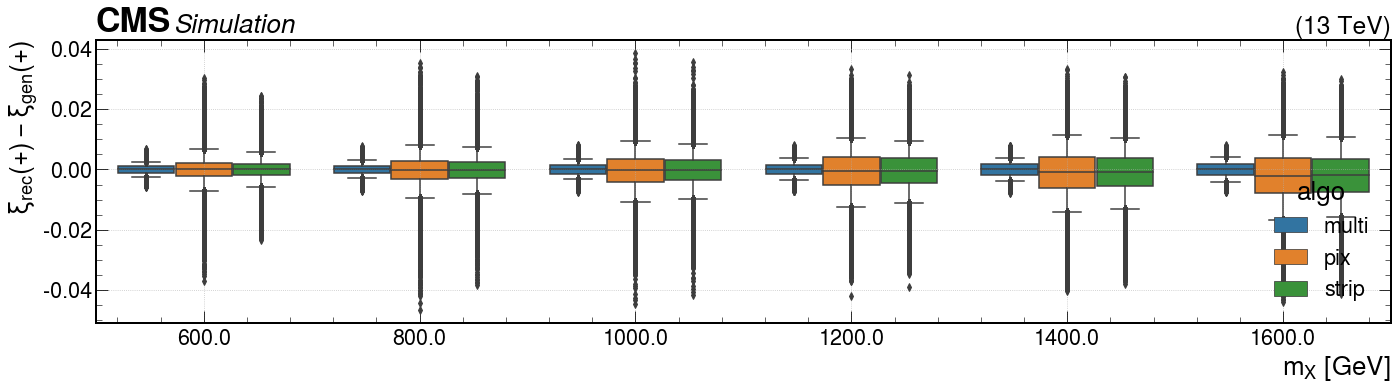

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

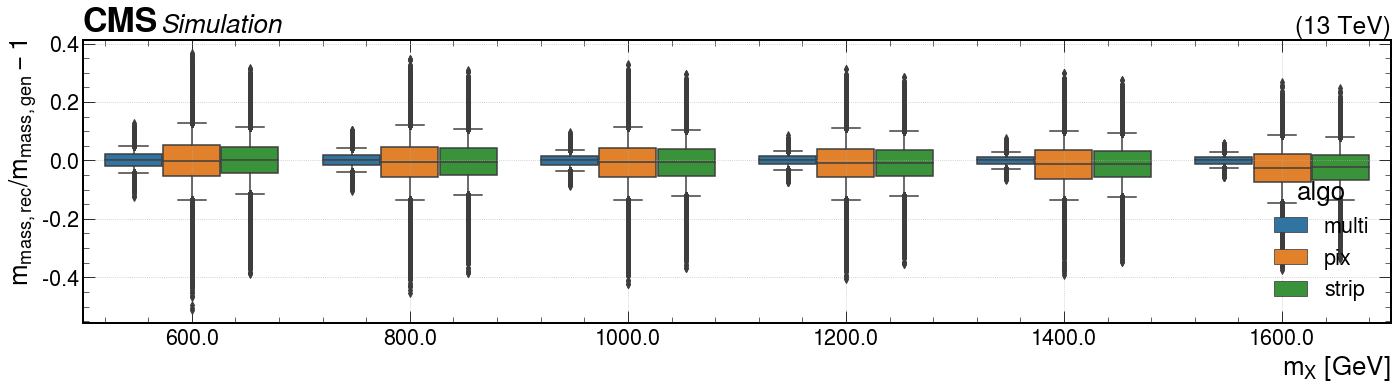

In [18]:
def fillResolutions():
    
    """ fill the combined PPS efficiency graphs (just needs to be done once, as it'll store the results in a pickle file) """

    resolSummary=[]
    
    for a in algos:
        
        #compute resolutions per algo
        resolSummary.append( df[['mX','csiPos_%s'%a,'csiNeg_%s'%a]].copy() )
        resolSummary[-1]['algo']      = a
        resolSummary[-1]['resCsiPos'] = df['csiPos_%s'%a]-df['csiPos_gen']
        resolSummary[-1]['resCsiNeg'] = df['csiNeg_%s'%a]-df['csiNeg_gen']
        resolSummary[-1]['resMpp']    = df['mpp_%s'%a]/df['mpp_gen']-1
        resolSummary[-1]['resMmass']  = df['mmass_%s'%a]/df['mmass_gen']-1

        #require both arms in acceptance
        mask=(resolSummary[-1]['csiPos_%s'%a]>0) & (resolSummary[-1]['csiNeg_%s'%a]>0)
        resolSummary[-1]=resolSummary[-1][mask]
                
    return pd.concat(resolSummary, ignore_index=True)

resolSummary = fillResolutions()   

#show the summaries as box plots
for var,varTitle in [('resCsiPos', r'$\xi_{rec}(+)-\xi_{gen}(+)$'),
                     ('resCsiNeg', r'$\xi_{rec}(-)-\xi_{gen}(-)$'),
                     ('resMpp',    r'$m_{rec}(pp)/m_{gen}(pp)-1$'),
                     ('resMmass',  r'$m_{mass,rec}/m_{mass,gen}-1$'),
                    ]:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 6)
    g=sns.boxplot(x="mX",y=var, hue="algo",data=resolSummary, ax=ax,whis=[5, 95])
    plt.setp(ax.get_legend().get_texts())
    plt.setp(ax.get_legend().get_title())
    ax.set_xlabel(r'm$_{X}$ [GeV]')
    ax.set_ylabel(varTitle)
    hep.cms.label(loc=0)
    plt.grid(True)
    plt.tight_layout()

    for ext in ['png','pdf']:
        figName=os.path.join(outdir,'resol_{0}.{1}'.format(var,ext))
        plt.savefig( figName)
 
    plt.show()
        

In [19]:
for algo in resolSummary['algo'].unique():
    q=resolSummary[resolSummary['algo']==algo]['resMpp'].quantile(q=[0.16,0.50,0.84]).values
    print('algo={} bias={} resol={}'.format(algo,q[1],0.5*(q[2]-q[0])))

algo=multi bias=0.00028502941131591797 resol=0.01979902148246765
algo=pix bias=-0.00518488883972168 resol=0.06568120360374449
algo=strip bias=-0.004373669624328613 resol=0.05851484656333923
